In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import colors
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry
from collections import defaultdict

In [3]:
flist = sorted(glob.glob("poreData/likelyMinEnergyStructures_pore_0-1/*_pore.mat"))
print(len(flist))

845


In [5]:
cifs = np.asarray([fname.split("/")[-1].split("zz_")[-1].split("_pore")[0] for fname in flist])[:,None]
print(cifs[:5])

[['ABWff-[1,0,1]-L-0.732814_0-U-0.748843_0-ss-12.8142965856']
 ['ABWff-[1,0,1]-L-0.732814_0-U-0.748843_0-ss-6.43686394024']
 ['ACOff-[1,1,0]-L-0.674661_0-U-0.674735_0-ss-14.0182230666']
 ['ACOff-[1,1,0]-L-0.674661_0-U-0.674735_0-ss-7.12771441351']
 ['AEIff-[0,0,1]-L-0.166088_0-U-0.666091_0-ss-27.551659809']]


In [6]:
columns = ["cif", "pld", "lcd", "asa", "av", "psd mean", "psd std", "n_paths", "paths mean", "paths std", "xdim", "ydim", "zdim", "n_channels"]
table = np.zeros((len(flist), 13))

paths_list = []
psd_list = []
dim_list = []
area_list = []
h_list = []
for i, fname in enumerate(flist):
    s = sio.loadmat(fname)
    table[i, 0] = s['pld'][0]
    table[i, 1] = s['lcd'][0]
    table[i, 2] = s['asa'][0]
    table[i, 3] = s['av'][0]
    psd_list.append(s['psd'][0])
    table[i, 4] = np.mean(s['psd'][0])
    table[i, 5] = np.std(s['psd'][0])
    if len(s['paths']) is not 0:
        table[i, 6] = len(s['paths'][0])
        paths_list.append(s['paths'][0])
    table[i, 7] = np.mean(s['paths'])
    table[i, 8] = np.std(s['paths'])
    table[i, 9] = s['dim'][0][0]
    table[i, 10] = s['dim'][0][1]
    table[i, 11] = s['dim'][0][2]
    dim_list.append(s['dim'][0][0]*s['dim'][0][1]*s['dim'][0][2])
    area_list.append(s['dim'][0][0]*s['dim'][0][1]+ s['dim'][0][0]*s['dim'][0][2] + s['dim'][0][1]*s['dim'][0][2])
    if len(s['paths']) is not 0:
        table[i, 12] = s['n_paths'][0]
table = np.concatenate([cifs, table], axis=1)
vols = np.asarray(dim_list)
areas = np.asarray(area_list)

In [7]:
df = pd.DataFrame(data=table, columns=columns)
for col in columns[1:]:
    df[col] = df[col].astype(float)
df.head(5)

,cif,pld,lcd,asa,av,psd mean,psd std,n_paths,paths mean,paths std,xdim,ydim,zdim,n_channels
0,"ABWff-[1,0,1]-L-0.732814_0-U-0.748843_0-ss-12....",2.335938,5.234501,3484.15,2197.534,1.117536,0.519107,858.0,2.109290,0.510760,10.6,25.9,14.3,1.0
1,"ABWff-[1,0,1]-L-0.732814_0-U-0.748843_0-ss-6.4...",2.476562,5.234501,1851.98,1252.336,1.183416,0.541531,900.0,3.782006,1.552950,10.6,25.8,7.9,1.0
2,"ACOff-[1,1,0]-L-0.674661_0-U-0.674735_0-ss-14....",3.460938,5.477225,7121.32,4907.140,1.137717,0.578541,8236.0,2.303097,0.601615,19.7,27.6,15.4,1.0
3,"ACOff-[1,1,0]-L-0.674661_0-U-0.674735_0-ss-7.1...",3.601562,5.549775,3831.73,2838.214,1.181352,0.597880,6382.0,3.360963,1.542757,19.7,27.6,8.6,1.0
4,"AEIff-[0,0,1]-L-0.166088_0-U-0.666091_0-ss-27....",3.882812,7.924645,14463.39,11987.179,1.444251,0.832817,2550.0,1.639780,0.189453,25.8,25.3,29.5,1.0


In [8]:
df.describe()

,pld,lcd,asa,av,psd mean,psd std,n_paths,paths mean,paths std,xdim,ydim,zdim,n_channels
count,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,8.450000e+02,845.000000,845.000000,845.000000,845.000000,845.000000,845.0
mean,3.358256,8.213787,22501.109349,18620.731836,1.368449,0.774593,3.327569e+04,2.259600,0.558609,28.031834,35.287574,31.411953,1.0
std,1.660856,2.048214,21211.893167,19651.949119,0.254692,0.198149,1.483506e+05,1.049433,0.631486,12.389115,18.448075,21.106946,0.0
min,1.351562,4.024922,1010.220000,908.649000,0.902637,0.348362,5.500000e+01,1.205015,0.015980,10.000000,9.300000,6.600000,1.0
25%,2.054688,6.743886,8809.830000,6617.779000,1.194612,0.632322,1.394000e+03,1.581776,0.139656,19.100000,21.700000,15.700000,1.0
50%,3.039062,7.924645,15431.880000,12822.459000,1.323673,0.743220,4.692000e+03,1.910508,0.344544,26.400000,29.200000,25.000000,1.0
75%,4.164062,9.400000,28560.920000,24000.485000,1.491482,0.882301,1.943000e+04,2.610474,0.734836,33.400000,44.200000,41.300000,1.0
max,9.085938,17.046993,222565.020000,225341.055000,2.985877,1.579357,3.033120e+06,10.003982,5.346266,69.600000,91.200000,153.000000,1.0


In [9]:
df.to_csv("csv/slabs_minEnergy.csv", sep=',')

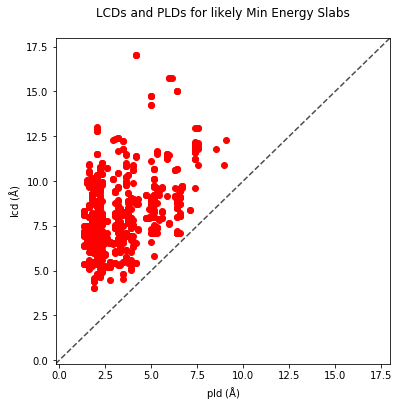

In [10]:
l1 = np.array(df["pld"])
l2 = np.array(df["lcd"])

plt.figure(figsize=(6, 6))
plt.scatter(l1, l2, c="r")
plt.title("LCDs and PLDs for likely Min Energy Slabs\n")
plt.xlabel("pld $(\mathrm{\AA})$")
plt.ylabel("lcd $(\mathrm{\AA})$")
plt.xlim([-0.2, 18.0])
plt.ylim([-0.2, 18.0])
plt.plot([-0.2, 18.0], [-0.2, 18.0], ls="--", c=".3")
plt.show()

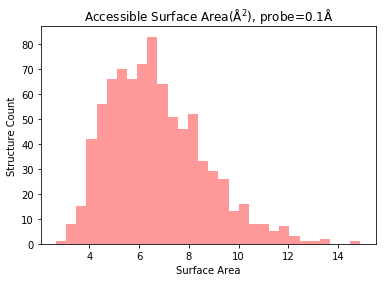

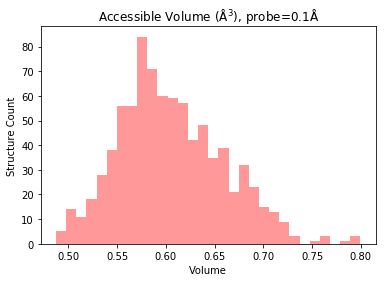

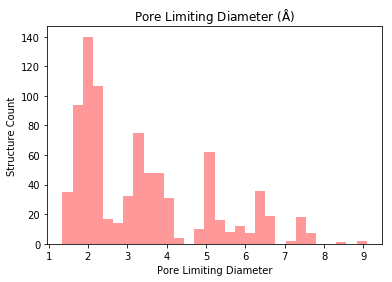

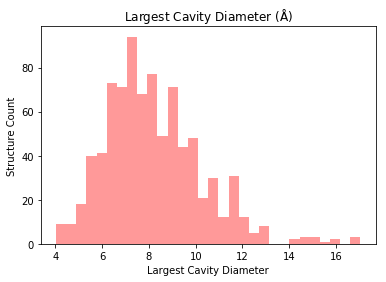

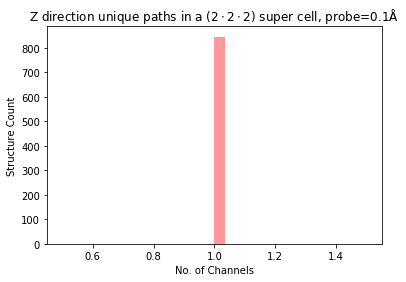

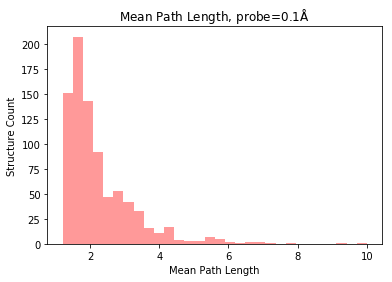

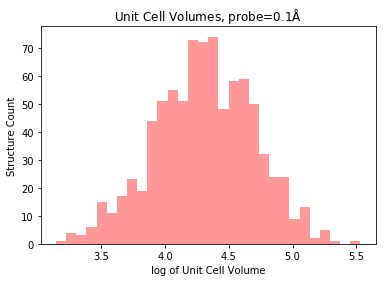

In [11]:
l = np.array(df["asa"])
sns.distplot(l/areas, bins=30, kde=False, color="r")
plt.title("Accessible Surface Area$(\mathrm{\AA}^2)$, probe=0.1$\mathrm{\AA}$")
plt.xlabel("Surface Area")
plt.ylabel("Structure Count")
plt.show()

l = np.array(df["av"])
sns.distplot(l/vols, bins=30, kde=False, color="r")
plt.title("Accessible Volume $(\mathrm{\AA}^3)$, probe=0.1$\mathrm{\AA}$")
plt.xlabel("Volume")
plt.ylabel("Structure Count")
plt.show()

l = np.array(df["pld"])
sns.distplot(l, bins=30, kde=False, color="r")
plt.title("Pore Limiting Diameter $(\mathrm{\AA})$")
plt.xlabel("Pore Limiting Diameter")
plt.ylabel("Structure Count")
plt.show()

l = np.array(df["lcd"])
sns.distplot(l, bins=30, kde=False, color="r")
plt.title("Largest Cavity Diameter $(\mathrm{\AA})$")
plt.xlabel("Largest Cavity Diameter")
plt.ylabel("Structure Count")
plt.show()

l = np.array(df["n_channels"])
sns.distplot(l, bins=30, kde=False, color="r")
plt.title("Z direction unique paths in a $(2\cdot 2\cdot 2)$ super cell, probe=0.1$\mathrm{\AA}$")
plt.xlabel("No. of Channels")
plt.ylabel("Structure Count")
plt.show()

l = np.array(df["paths mean"])
l[np.isnan(l)] = 0
sns.distplot(l, bins=30, kde=False, color="r")
plt.title("Mean Path Length, probe=0.1$\mathrm{\AA}$")
plt.xlabel("Mean Path Length")
plt.ylabel("Structure Count")
plt.show()

l = vols.copy()
l[np.isnan(l)] = 0
sns.distplot(np.log10(l), bins=30, kde=False, color="r")
plt.title("Unit Cell Volumes, probe=0.1$\mathrm{\AA}$")
plt.xlabel("log of Unit Cell Volume")
plt.ylabel("Structure Count")
plt.show()

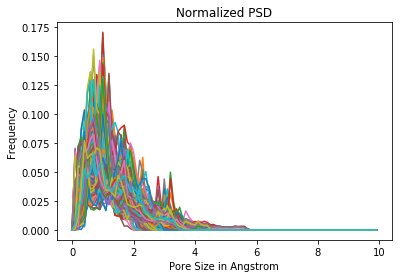

In [14]:
nbins = 100
psd_norm = np.zeros((len(psd_list), nbins))

for indx, psd in enumerate(psd_list):
    psd_norm[indx, :] = (np.histogram(psd, bins=nbins, range=(0,10))[0] / len(psd))

for i in range(230):
    psd = psd_norm[i]
    plt.plot(np.arange(100) * 0.1, psd)

plt.ylabel("Frequency")
plt.xlabel("Pore Size in Angstrom")
plt.title("Normalized PSD")
plt.show()

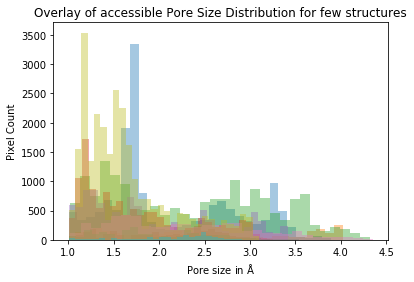

In [17]:
np.random.seed(17263)
n_indx = np.random.randint(low=0, high=len(flist)-1, size=10)
for i in n_indx:
    s = sio.loadmat(flist[i])
    psd = (s['psd'][0])
    sns.distplot(psd, bins=30, kde=False)
plt.title("Overlay of accessible Pore Size Distribution for few structures")
plt.xlabel("Pore size in $\mathrm{\AA}$")
plt.ylabel("Pixel Count")
plt.show()